<a href="https://colab.research.google.com/github/PARTHIBAN-M-2006/CNN_FINGERPRINT_RECONSTRUCTION_MODEL/blob/main/CNN_FINGERPRINT_RECONSTRUCTION_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


In [ ]:
IMG_SIZE = 128

def load_clean_images(folder):
    images = []
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        images.append(img)

    images = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    return images

dataset_path = "/content/drive/MyDrive/dataset_cnn"
clean_images = load_clean_images(dataset_path)

print("Clean images:", clean_images.shape)


Clean images: (6014, 128, 128, 1)


In [ ]:
def realistic_mask(img):
    img = img.copy()
    h, w = img.shape

    # Random rectangle (black or white)
    if np.random.rand() < 0.7:
        x1 = np.random.randint(0, w-40)
        y1 = np.random.randint(0, h-40)
        x2 = x1 + np.random.randint(30, 70)
        y2 = y1 + np.random.randint(30, 70)
        img[y1:y2, x1:x2] = np.random.choice([0.0, 1.0])

    # Random circular white hole (like user image)
    if np.random.rand() < 0.7:
        cx = np.random.randint(30, w-30)
        cy = np.random.randint(30, h-30)
        r = np.random.randint(15, 30)
        Y, X = np.ogrid[:h, :w]
        mask = (X-cx)**2 + (Y-cy)**2 <= r*r
        img[mask] = 1.0

    return img


In [ ]:
masked_images = []
for img in clean_images:
    masked = realistic_mask(img.squeeze())
    masked_images.append(masked)

masked_images = np.array(masked_images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

print("Masked images:", masked_images.shape)


Masked images: (6014, 128, 128, 1)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    masked_images,
    clean_images,
    test_size=0.2,
    random_state=42
)


In [ ]:
input_img = Input(shape=(128,128,1))

# Encoder
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(128, (3,3), activation='relu', padding='same')(x)

# Decoder
x = UpSampling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)

x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)

output = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

model = Model(input_img, output)


In [ ]:
def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
    return mse + 0.5 * ssim

model.compile(
    optimizer=Adam(1e-4),
    loss=combined_loss
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,217 (723.50 KB)

 Trainable params: 185,217 (723.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, Y_test)
)


Epoch 1/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - loss: 0.4594 - val_loss: 0.3589
Epoch 2/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.3483 - val_loss: 0.3116
Epoch 3/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.3044 - val_loss: 0.2848
Epoch 4/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.2810 - val_loss: 0.2684
Epoch 5/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.2657 - val_loss: 0.2551
Epoch 6/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.2542 - val_loss: 0.2434
Epoch 7/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.2405 - val_loss: 0.2315
Epoch 8/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.2307 - val_loss: 0.2206
Epoch 9/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.2208 - val_loss: 0.2119
Epoch 10/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.2125 - val_loss: 0.2056
Epoch 11/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.2046 - val_loss: 0.1997
Epoch 12/100
301/301 ━━━━━━━

In [ ]:
model.save("fingerprint_reconstruction.h5")


In [ ]:
model = load_model(
    "/content/cnn_fingerprint_reconstruction.h5",
    custom_objects={"combined_loss": combined_loss}
)


NameError: name 'combined_loss' is not defined

In [ ]:
def test_user_image(model):
    uploaded = files.upload()

    for filename in uploaded.keys():
        img = cv2.imread(filename)
        masked = preprocess(img)

        # model input
        inp = masked.reshape(1,128,128,1)

        # reconstruction (THIS LINE YOU ALREADY HAD)
        recon = model.predict(inp, verbose=0)[0].reshape(128,128)

        # ADD THIS LINE IMMEDIATELY AFTER ↑
        enhanced = enhance_fingerprint(recon)

        # display
        plt.figure(figsize=(15,4))

        plt.subplot(1,3,1)
        plt.title("User Masked Input")
        plt.imshow(masked, cmap='gray')
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.title("Reconstructed Output")
        plt.imshow(recon, cmap='gray')
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.title(" Clean Output")
        plt.imshow(enhanced, cmap='gray')
        plt.axis('off')

        plt.show()


In [ ]:
def enhance_fingerprint(img):
    img = (img * 255).astype(np.uint8)

    # CLAHE for contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # Sharpening
    kernel = np.array([[0,-1,0],
                       [-1,5,-1],
                       [0,-1,0]])
    img = cv2.filter2D(img, -1, kernel)

    img = img / 255.0
    return img


Saving Screenshot 2026-02-09 081541.png to Screenshot 2026-02-09 081541.png


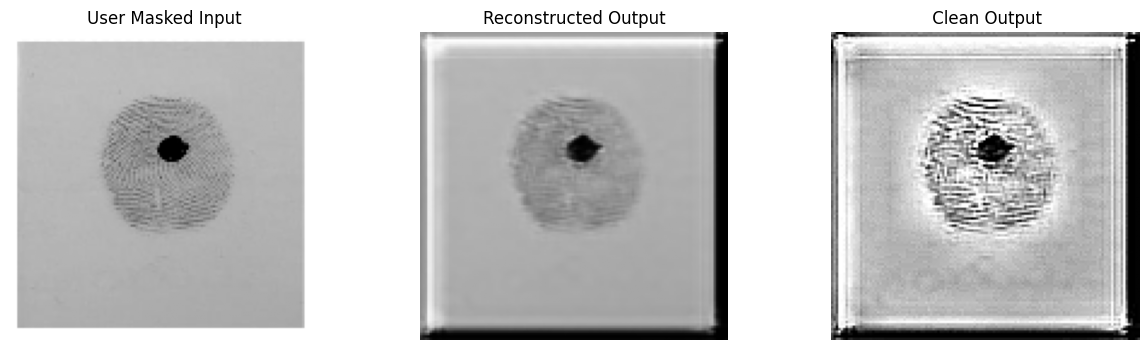

In [ ]:
test_user_image(model)
